<a href="https://colab.research.google.com/github/Sarthak2597/Quantum-Simulations/blob/main/VQE_HLi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installing a few dependencies
!pip install --upgrade seaborn==0.10.1
!pip install --upgrade scikit-learn==0.23.1
!pip install --upgrade matplotlib==3.2.0
!pip install --upgrade pandas==1.0.4
!pip install --upgrade qiskit==0.19.6 
!pip install --upgrade plotly==4.9.0

# the output will be cleared after installation
from IPython.display import clear_output
clear_output()

In [4]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

In [16]:
molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
distances = np.arange(0.5,4.25,0.25)
vqe_energies= []
hf_energies = []
exact_energies = []

In [17]:
for i,d in enumerate(distances):
  print('step',i)

  #setup exp
  driver = PySCFDriver(molecule.format(d/2),basis='sto3g')
  qmolecule = driver.run()
  operator = Hamiltonian(qubit_mapping = QubitMappingType.PARITY,
                         two_qubit_reduction = True, freeze_core = True,
                         orbital_reduction = [-3,-2])
  qubit_op,aux_ops = operator.run(qmolecule)

  #exact result
  exact_result = NumPyMinimumEigensolver(qubit_op,aux_operators = aux_ops).compute_minimum_eigenvalue() 
  exact_result = operator.process_algorithm_result(exact_result)

  #VQE
  optimizer = SLSQP(maxiter = 1000)
  initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                              operator.molecule_info['num_particles'],
                              qubit_mapping=operator._qubit_mapping,
                              two_qubit_reduction=operator._two_qubit_reduction)
  
  var_form = UCCSD(num_orbitals = operator.molecule_info['num_orbitals'],
                   num_particles=operator.molecule_info['num_particles'],
                   initial_state=initial_state,
                   qubit_mapping=operator._qubit_mapping,
                   two_qubit_reduction = operator._two_qubit_reduction)
  
  algo=VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)

  vqe_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))

  vqe_result=operator.process_algorithm_result(vqe_result)

  exact_energies.append(exact_result.energy)
  vqe_energies.append(vqe_result.energy)
  hf_energies.append(vqe_result.hartree_fock_energy)

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14


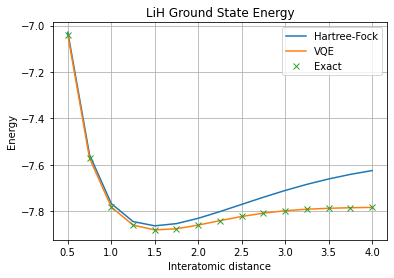

In [21]:
pylab.plot(distances,hf_energies,label = 'Hartree-Fock')
pylab.plot(distances,vqe_energies,'-', label='VQE')
pylab.plot(distances,exact_energies,'x', label='Exact')

pylab.grid(True)

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc = 'upper right')